In [1]:
from scipy.io import loadmat
import tempfile
import glob
import re
import cv2
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import binary_dilation
from scipy.ndimage import median_filter

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tenacity import retry, stop_after_attempt, wait_fixed

In [2]:
# Define the retry decorator
@retry(stop=stop_after_attempt(4), wait=wait_fixed(3))
def read_tiff_file(fn):
    print('Reading:', fn)
    A = ScanImageTiffReader(fn)
    Ad = np.array(A.data(), dtype=np.float32).T
    return Ad

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge effects.
    Useful for exponential bleaching curves.

    Parameters:
    D (numpy.ndarray): Input data array where the first dimension is time.
    mode (str): Smoothing mode, either 'movmedian' or 'movmean'.
    window (int): Window size for smoothing.

    Returns:
    numpy.ndarray: Smoothed data array.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = min(window, D.shape[0])
    t = np.arange(1, window + 1)
    p = np.vstack([t, np.ones_like(t)]).T

    if mode == 'movmedian':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).mean().values
    else:
        raise ValueError("Mode must be either 'movmedian' or 'movmean'")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t - 1, ix]))[0]
        if len(inds) > 0:
            slope, intercept, _, _, _ = linregress(inds + 1, D[inds, ix])
            lVals[:, ix] = p @ np.array([slope, intercept])

    weights = t / len(t)
    sVals[t - 1, :] = weights[:, np.newaxis] * sVals[t - 1, :] + (1 - weights[:, np.newaxis]) * lVals

    if mode == 'movmedian':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).mean().values

    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)

    return sVals


In [4]:
import numpy as np
import scipy.ndimage as ndimage
from skimage.filters import difference_of_gaussians
import matplotlib.pyplot as plt
from skimage.morphology import square
import numpy as np
from scipy.linalg import svd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.sparse.linalg import svds
from scipy.ndimage import convolve, shift
from scipy.stats import scoreatpercentile
from scipy.ndimage import gaussian_filter
from scipy import stats
import pdb

def localize_flashes_bergamo(IM, aData, params, doPlot=False):
    # Inputs:
    # IM:        3D recording, X x Y x Time
    # aData:     alignment metadata

    
    tau = params['tau_s'] / (params['frametime'] * params['dsFac'])  # time constant in frames
    params['tau_frames'] = tau
    sigma = params['sigma_px']  # space constant in pixels

    denoiseWindow = params['denoiseWindow_samps']
    baselineWindow = int(np.ceil(params['baselineWindow_Glu_s'] / (params['frametime'] * params['dsFac'])))

    nans = np.isnan(IM)
    IMavg = np.nanmean(IM, axis=2)
    IMgamma = np.sqrt(np.maximum(0, IMavg))

    BG = np.percentile(IMavg[~np.isnan(IMavg)], 10)

    # Subtract background, relevant for Bergamo only (not SLAP2)
    IMf = IM - BG
    plt.imshow(np.mean(IMf, axis =2))
    plt.show()
    
    IMf[nans] = 0

    # plt.figure()
    # plt.imshow(IMf[:,:,1])
    # plt.show()

    # create a Difference of Gaussians filter (mean 0) that highights spots
    size = 2 * int(np.ceil(10 * sigma)) + 1
    DoGfilt = np.zeros((size, size))
    DoGfilt[size // 2, size // 2] = 1
    DoGfilt = gaussian_filter(DoGfilt, sigma) - gaussian_filter(DoGfilt, 5 * sigma)
    DoGfilt = DoGfilt - np.mean(DoGfilt)
    
    # Apply spatial filter
    # IMf = ndimage.convolve(IMf, np.ones((1, 1, 1)), mode='constant', cval=0.0)
    # # plt.figure()
    # # plt.imshow(IMf[:,:,1])
    # # plt.show()
    # IMstruct = cv2.filter2D(np.maximum(0, IMavg), -1, np.ones((1, 1)), borderType=cv2.BORDER_CONSTANT)
    if IMf.ndim == 3:
        IMf_filtered = np.zeros_like(IMf)
        for i in range(IMf.shape[2]):
            IMf_filtered[:,:,i] = cv2.filter2D(IMf[:,:,i], -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)
        IMf = IMf_filtered
    else:
        IMf = cv2.filter2D(IMf, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)

    # # For IMf
    # IMf = cv2.filter2D(IMf, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)

    # For IMstruct
    IMavg_positive = np.maximum(0, IMavg)
    IMstruct = cv2.filter2D(IMavg_positive, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)
    
    # Highpass filter in time
    IMf[nans] = np.nan
    IMf = IMf - ndimage.median_filter(IMf, size=(1, 1, baselineWindow))
    nans = np.isnan(IMf)

    # Remove motion-associated variance
    IMf = decorrelate_motion(IMf, IMstruct, aData, params)

    # plt.figure()
    # plt.imshow(IMf[:,:,1])
    # plt.show()
    
    # Normalize by expected poisson noise
    IMavg_nans = np.isnan(IMavg)
    Pnoise = np.maximum(IMavg, 0)  # squared poisson noise
    Mnoise = np.sqrt(
        cv2.filter2D(np.roll(Pnoise, 1, axis=0) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_REFLECT)**2 +
        cv2.filter2D(np.roll(Pnoise, -1, axis=0) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_REFLECT)**2 +
        cv2.filter2D(np.roll(Pnoise, 1, axis=1) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_REFLECT)**2 +
        cv2.filter2D(np.roll(Pnoise, -1, axis=1) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_REFLECT)**2
    )


    IMnoise = np.sqrt(cv2.filter2D(Pnoise, -1, np.abs(DoGfilt), borderType=cv2.BORDER_REFLECT))  # total signal contributing to each measurement
    IMnoise = IMnoise + scoreatpercentile(IMnoise[~IMavg_nans], 33) + 0.2 * np.sqrt(Mnoise)  # add a noise floor to the dimmer pixels
    IMnoise[IMavg_nans] = np.nan
    
    # Add an extra dimension to IMnoise to match the shape of IMf
    IMnoise = IMnoise[:, :, np.newaxis]

    IMf = IMf / IMnoise

    # # Add an extra dimension to IMnoise to match the shape of IMf
    # IMnoise = IMnoise[:, :, np.newaxis]

    # IMf = IMf / IMnoise

    # Temporal matched filter
    IMf[nans] = 0
    mem = IMf[:, :, -1]
    gamma = np.exp(-1 / tau)
    for t in range(IMf.shape[2] - 1, -1, -1):
        IMf[:, :, t] = np.maximum(0, gamma * mem) + (1 - gamma) * IMf[:, :, t]
        mem = IMf[:, :, t]
    IMf[nans] = np.nan

    # Compute a summary image based on skewness
    summary = np.nanmean(IMf**3, axis=2)

    # Create a kernel
    kernel = np.ones((5,5),np.uint8)

    # Perform dilation on the mask of NaN values
    dilated_mask = cv2.dilate(np.isnan(summary).astype(np.uint8), kernel, iterations = 1)

    # Set the dilated areas to NaN
    summary[dilated_mask == 1] = np.nan

    P = get_tiled_peaks(IMf, IMavg, summary)

    # Plot a figure
    if doPlot:
        plot_summary(summary, IMgamma, P)

    return summary, P, params


# def plot_summary(summary, IMgamma, P):
#     red = summary / np.percentile(summary[~np.isnan(summary)], 99)
#     cyan = IMgamma / np.percentile(IMgamma[~np.isnan(IMgamma)], 99)
    
#     # Clip the values to the range [0, 1]
#     red = np.clip(red, 0, 1)
#     cyan = np.clip(cyan, 0, 1)
    
#     # Stack the channels and display the image
#     rgb_image = np.dstack((red, cyan, cyan))
#     plt.imshow(rgb_image)
#     plt.scatter(P['col'], P['row'], s=10 * (P['val'] / np.mean(P['val'])) ** 2, edgecolors='m', facecolors='none')
#     plt.show()

def plot_summary(summary, IMgamma, P):
    red = summary / np.nanpercentile(summary, 99)
    cyan = IMgamma / np.nanpercentile(IMgamma, 99)
    rgb = np.dstack((red, cyan, cyan))

    rgb_normalized = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))

    plt.figure()
    # plt.imshow(rgb_normalized)
    plt.imshow( np.dstack((red, cyan, cyan)))
    
    plt.scatter(P['col'], P['row'], s=10 * (P['val'] / np.mean(P['val'])) ** 2, edgecolors='m', facecolors='none')
    plt.show()

def get_tiled_peaks(IM, IMavg, summary):
    nan_mask = np.isnan(IM).astype(np.uint8)

    # Create a 5x5 kernel of ones
    kernel = np.ones((5, 5), np.uint8)

    dilated = np.empty_like(nan_mask)
    for i in range(nan_mask.shape[2]):
        dilated[:, :, i] = cv2.dilate(nan_mask[:, :, i], kernel)

    # Invert the result to get the valid mask
    valid = ~dilated.astype(bool)
    peaks = valid
    
    for dim in range(3):
        peaks = peaks & (IM > np.roll(IM, 1, axis=dim)) & (IM > np.roll(IM, -1, axis=dim))
        
    # linInds = np.where(peaks)
    # vvv = IM[linInds]
    # rrr, ccc, ttt = linInds

    linInds = np.where(peaks.flatten())[0]
    vvv = IM.flatten()[linInds]
    rrr, ccc, ttt = np.unravel_index(linInds, peaks.shape)

    print("rrr, ccc, ttt, peaks.shape, linInds:", len(rrr), len(ccc), len(ttt), peaks.shape, len(linInds))

    sz = IM.shape
    tilesize = 64
    tilestartsR = np.arange(1, sz[0] - tilesize // 4, tilesize // 2)
    tileendsR = np.minimum(sz[0], tilestartsR + tilesize - 1)
    tilestartsC = np.arange(1, sz[1] - tilesize // 4, tilesize // 2)
    tileendsC = np.minimum(sz[1], tilestartsC + tilesize - 1)

    summaryVals = summary[rrr, ccc]

    keep = np.zeros(len(ttt), dtype=bool)  # which events to keep
    vNorm = np.zeros(len(ttt))  # the event sizes, Z-scored

    for rix in range(len(tilestartsR)):
        for cix in range(len(tilestartsC)):
            selStats = (rrr >= tilestartsR[max(0, rix-1)]) & (rrr <= tileendsR[min(len(tileendsR)-1, rix+1)]) & \
                    (ccc >= tilestartsC[max(0, cix-1)]) & (ccc <= tileendsC[min(len(tileendsC)-1, cix+1)])

            S = summary[tilestartsR[max(0, rix-1)]:tileendsR[min(len(tileendsR)-1, rix+1)]+1, 
                        tilestartsC[max(0, cix-1)]:tileendsC[min(len(tileendsC)-1, cix+1)]+1]
            Sp = np.percentile(S.flatten(), [1, 33])
            Sthresh = Sp[1] + 5 * (Sp[1] - Sp[0])
            selS = summaryVals > Sthresh

            vals = vvv[selStats & selS]
            ptile = np.percentile(vals, [1, 50])
            vals = 3 * (vals - ptile[1]) / (ptile[1] - ptile[0])
            thresh = ptile[1] + 2 * (ptile[1] - ptile[0])  # threshold is 2*[98% confint], corresponding to an SNR of ~6
            selTile = (rrr >= tilestartsR[rix]) & (rrr <= tileendsR[rix]) & \
                    (ccc >= tilestartsC[cix]) & (ccc <= tileendsC[cix]) & (vvv > thresh) & selS
            keep[selTile] = True
            vNorm[selStats & selS] = np.maximum(vNorm[selStats & selS], vals)


    rrr = rrr[keep]
    ccc = ccc[keep]
    ttt = ttt[keep]
    vvv = vNorm[keep]

    # Upsample for superresolution
    pR = []
    pC = []

    for peakIx in range(len(ttt)-1, -1, -1):
        R = IM[rrr[peakIx]+np.arange(-1,2), ccc[peakIx], ttt[peakIx]]
        C = IM[rrr[peakIx], ccc[peakIx]+np.arange(-1,2), ttt[peakIx]]

        ratioR = min(1e6, (R[1] - R[0]) / (R[1] - R[2]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        pR.append(rrr[peakIx] - dR)

        ratioC = min(1e6, (C[1] - C[0]) / (C[1] - C[2]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        pC.append(ccc[peakIx] - dC)

    print("pR.shape:", len(pR))
    P = {'row': pR, 'col': pC, 't': ttt, 'val': vvv}
    return P
    
def decorrelate_motion(IM, IMavg, aData, window):
    nanFrames = np.all(np.isnan(IM), axis=(0, 1))
    IMnan = np.isnan(IM)
    sz = IM.shape
    nPCs = 20
    goodPixels = np.mean(~IMnan, axis=2) > 0.9
    IM2 = IM.copy()
    IM2[IMnan] = 0
    IM2 = IM2[:, :, ~nanFrames].reshape(sz[0] * sz[1], -1)
    IM2 = IM2 - np.mean(IM2, axis=1, keepdims=True)
    
    def imtranslate(image, shift_val):
        return shift(image, shift_val, mode='nearest')
    
    imageGrads = np.stack([
        IMavg - imtranslate(IMavg, [1, 0]),
        IMavg - imtranslate(IMavg, [0, 1]),
        IMavg - imtranslate(IMavg, [-1, 0]),
        IMavg - imtranslate(IMavg, [0, -1])
    ], axis=2)
    imageGrads = imageGrads.reshape(sz[0] * sz[1], -1)
    
    U, S, Vt = svds(IM2[goodPixels.ravel(), :], k=nPCs)
    b = np.linalg.lstsq(imageGrads[goodPixels.ravel(), :], U, rcond=None)[0]
    correction = (imageGrads @ b) @ np.diag(S) @ Vt
    IM[:, :, ~nanFrames] -= correction.reshape(sz[0], sz[1], -1)
    return IM



Temporary file created at: /tmp/tmp41tir8z2.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial4_DOWNSAMPLED-2x.tif
Trial: 8
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial9_DOWNSAMPLED-2x.tif
params['dsFac']: 2


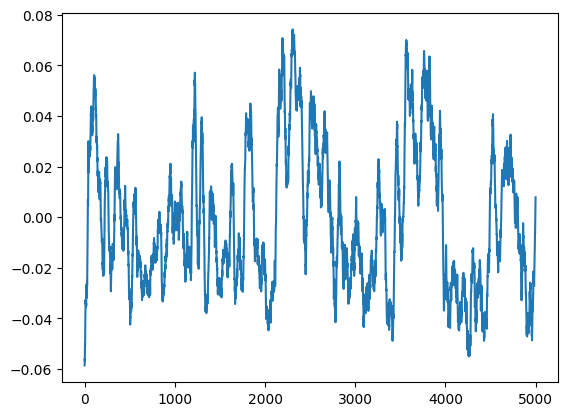

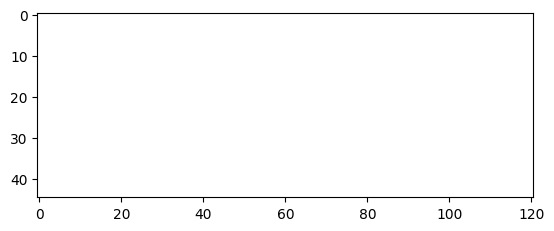

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6777372..8.898563].


rrr, ccc, ttt, peaks.shape, linInds: 329772 329772 329772 (45, 121, 5000) 329772
pR.shape: 13


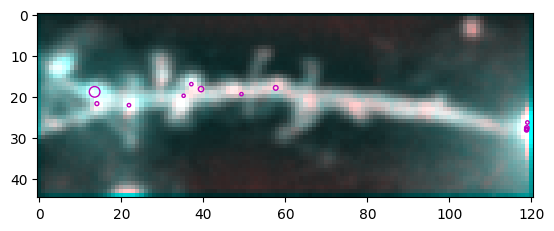

Trial: 7
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial8_DOWNSAMPLED-2x.tif
params['dsFac']: 2


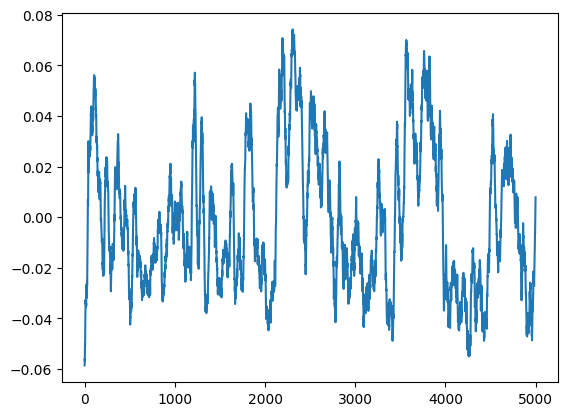

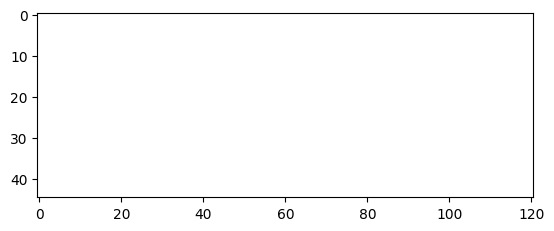

In [5]:
import os
import glob
import pandas as pd
import re
import tempfile
import h5py
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader

savedr = '/root/capsule/scratch/test1/'

# Define the directory path
fns = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/'

# Define the pattern to match files
pattern = os.path.join(fns, '*_Trial*_DOWNSAMPLED-2x.tif')

# Use glob to find all files matching the initial pattern
initial_matching_files = glob.glob(pattern)

# Define a regular expression to match files ending with 'Trial<int>.tif'
regex = re.compile(r'.*_Trial\d+_DOWNSAMPLED-2x.tif$')

# Filter the files using the regular expression
strict_matching_files = [f for f in initial_matching_files if regex.match(f)]

params = {
    "tau_s": 0.027,  # time constant in seconds for glutamate channel; from Aggarwal et al 2023 Fig 5
    "sigma_px": 1.33,  # space constant in pixels
    "eventRateThresh_hz": 1/10,  # minimum event rate in Hz
    "sparseFac": 0.1,  # sparsity factor for shrinking sources in space, 0-1, higher value makes things sparser
    "nmfIter": 5,  # number of iterations of NMF refinement
    "dXY": 3,  # how large sources can be (radius), pixels
    "upsample": 1,  # how many times to upsample the imaging resolution for finding local maxima to identify sources; affects maximum source density
    "nmfBackgroundComps": 0,  # <=4, max number of background components to use for NMF. If 0, we compute F0 instead of fitting background
    "denoiseWindow_samps": 35,  # number of samples to average together for denoising
    "baselineWindow_Glu_s": 2,  # timescale for calculating F0 in glutamate channel, seconds
    "baselineWindow_Ca_s": 2  # timescale for calculating F0 in calcium channel, seconds
}

# Path to the original HDF5 file
original_gt_path = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial9_ALIGNMENTDATA.h5'

# Create a temporary file for the HDF5 operations
with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
    temp_file_path = temp_file.name

# Copy contents from the original HDF5 file to the temporary file
with h5py.File(original_gt_path, 'r') as original_gt, h5py.File(temp_file_path, 'w') as temp_gt:
    for key in original_gt.keys():
        original_gt.copy(key, temp_gt)

trialIx = 0

print(f"Temporary file created at: {temp_file_path}")

# Process the TIFF files
discardFrames = [None] * len(strict_matching_files)
rawIMs = [None] * len(strict_matching_files)
peaks = [None] * len(strict_matching_files)

# Read the first file to get the shape
first_fn = strict_matching_files[0]
first_IM = read_tiff_file(first_fn)

# Initialize meanIM
meanIM = np.full((first_IM.shape[0], first_IM.shape[1], 1, len(strict_matching_files)), np.nan)
actIM = []
strict_matching_files = sorted(strict_matching_files, key=lambda x: int(re.search(r'Trial(\d+)', x).group(1)))
for trialIx in range(len(strict_matching_files)-1, -1, -1):
    print('Trial:', trialIx)
    fn = strict_matching_files[trialIx]

    # Load the TIFF
    IM = read_tiff_file(fn)
    
    if IM.shape[1] < 100:
        raise ValueError(f'{fn} is very short')
    
    IM = IM.reshape(IM.shape[0], IM.shape[1], 1, -1)  # deinterleave
    
    meanIM[:, :, :, trialIx] = np.nanmean(IM, axis=3)

    # Load alignment data from the temporary file
    with h5py.File(temp_file_path, 'r+') as temp_gt:
        # Check if the dataset 'aData/dsFac' exists, create it if not
        if 'aData/dsFac' in temp_gt:
            dsFac_dset = temp_gt['aData/dsFac']
        else:
            dsFac_dset = temp_gt.create_dataset('aData/dsFac', data=round(len(temp_gt['aData/motionC'][()]) / len(temp_gt['aData/motionDSc'][()])))

        params['dsFac'] = dsFac_dset[()]
        print("params['dsFac']:", params['dsFac'])
        params['frametime'] = temp_gt['aData/frametime'][()]
        numChannels = temp_gt['aData/numChannels'][()]

        # Flatten aRankCorr
        aRankCorr_flat = np.ravel(temp_gt['aData/aRankCorr'])

        # Calculate the window size for the moving median
        window_size = int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))

        # Calculate the moving median using uniform_filter1d
        moving_median = uniform_filter1d(aRankCorr_flat, size=window_size)

        # Flatten the array
        rank_corr_flat = temp_gt['aData/aRankCorr'][()].flatten()

        # Apply the smoothExp function with 'movmedian'
        tmp = rank_corr_flat - smooth_exp(rank_corr_flat, 'movmedian', int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()]))))

        # Apply the smoothExp function with 'movmean'
        filtTmp = smooth_exp(tmp, 'movmean', int(np.ceil(0.2 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))) 

        plt.plot(filtTmp)
        plt.show()
        # Create a binary mask where filtTmp is less than -4 times the standard deviation
        threshold = -4 * np.std(filtTmp)
        binary_mask = filtTmp < threshold

        # Dilate the binary mask
        kernel = np.ones((1, 5), np.uint8)
        discardFrames[trialIx] = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

        # Assuming trialIx, IM, and discardFrames are defined
        rawIMs[trialIx] = np.squeeze(IM[:,:,0,:])
        rawIMs[trialIx][:,:,discardFrames[trialIx]] = np.nan

        if numChannels == 2:
            rawIM2s[trialIx] = np.squeeze(IM[:,:,1,:])
            rawIM2s[trialIx][:,:,discardFrames[trialIx]] = np.nan

        IMc, peaks[trialIx], params = localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, True)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge effects.
    Useful for exponential bleaching curves.

    Parameters:
    D (numpy.ndarray): Input data array where the first dimension is time.
    mode (str): Smoothing mode, either 'movmedian' or 'movmean'.
    window (int): Window size for smoothing.

    Returns:
    numpy.ndarray: Smoothed data array.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = min(window, D.shape[0])
    t = np.arange(1, window + 1)
    p = np.vstack([t, np.ones_like(t)]).T

    if mode == 'movmedian':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).mean().values
    else:
        raise ValueError("Mode must be either 'movmedian' or 'movmean'")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t - 1, ix]))[0]
        if len(inds) > 0:
            slope, intercept, _, _, _ = linregress(inds + 1, D[inds, ix])
            lVals[:, ix] = p @ np.array([slope, intercept])

    weights = t / len(t)
    sVals[t - 1, :] = weights[:, np.newaxis] * sVals[t - 1, :] + (1 - weights[:, np.newaxis]) * lVals

    if mode == 'movmedian':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).mean().values

    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)

    return sVals


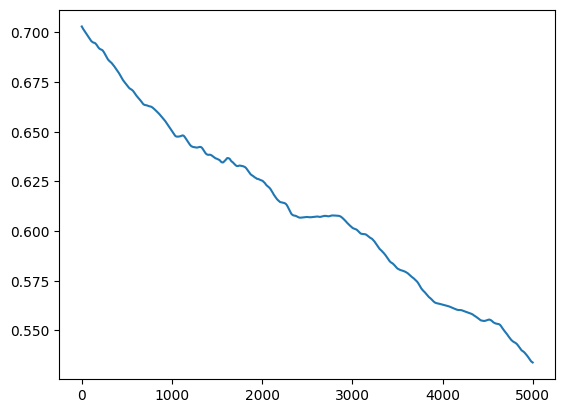

In [ ]:
tmp = smooth_exp(rank_corr_flat, 'movmedian', 2174)
plt.plot(smooth_exp(tmp, 'movmean', 44))

In [ ]:
import numpy as np
import pandas as pd

# Assuming aData is a dictionary with keys 'aRankCorr', 'frametime', and 'dsFac'
window_size = int(np.ceil(10 / (0.023 * 2)))

# Smooth data using moving median
smoothed = pd.Series(aRankCorr_flat).rolling(window=window_size, min_periods=10).median().to_numpy()

# Subtract smoothed data from original data
result = aRankCorr_flat - smoothed

plt.plot(result)


In [ ]:
import numpy as np
from scipy.signal import medfilt

# Calculate the window size
window_size = int(np.ceil(10 / (0.023 * 2)))
# Ensure the window size is odd
if window_size % 2 == 0:
    window_size += 1
# Apply the moving median filter
smoothed_data = medfilt(aRankCorr_flat, kernel_size=window_size)

# Subtract the smoothed data from the original data
result = aRankCorr_flat - smoothed_data

plt.plot(result)


# Test script:

In [ ]:

# Create a dummy 3D recording (X x Y x Time)
IM = np.random.rand(45, 150, 5000)  # 100x100 pixels, 50 time frames

# Create dummy alignment metadata
aData = {
    'motionDSc': np.random.rand(5000),  # Random motion data for columns
    'motionDSr': np.random.rand(5000)   # Random motion data for rows
}

# Create dummy parameters
params = {
    'tau_s': 0.027,  # Time constant in seconds
    'frametime': 0.0023,  # Frame time in seconds
    'dsFac': 2,  # Downsampling factor
    'sigma_px': 1.33,  # Space constant in pixels
    'denoiseWindow_samps': 35,  # Denoise window in samples
    'baselineWindow_Glu_s': 2.0  # Baseline window in seconds
}

# Set doPlot to True or False
doPlot = True

summary, P, params = localize_flashes_bergamo(IM, aData, params, doPlot)


In [ ]:
import numpy as np

# Create a dummy 3D recording (X x Y x Time)
IM = read_tiff_file('/root/capsule/scratch/SIMULATION_scan_00003_Standard2_Trial1_Unregistered_20230815_155327_REGISTERED_DOWNSAMPLED-8x.tif')  # 100x100 pixels, 50 time frames
np.random.seed(0)

# Create dummy alignment metadata
aData = {
    'motionDSc': np.random.uniform(-1.000, 1.000, 1250),  # Random values for columns
    'motionDSr': np.random.uniform(-1.000, 1.000, 1250)   # Random values for rows
}

# Create dummy parameters
params = {
    'tau_s': 0.027,  # Time constant in seconds
    'frametime': 0.023,  # Frame time in seconds
    'dsFac': 3,  # Downsampling factor
    'sigma_px': 1.33,  # Space constant in pixels
    'denoiseWindow_samps': 35,  # Denoise window in samples
    'baselineWindow_Glu_s': 2.0  # Baseline window in seconds
}

# Set doPlot to True or False
doPlot = True

# Call the function
summary, P, params = localize_flashes_bergamo(IM, aData, params, doPlot)

In [ ]:
import h5py
from scipy.io import savemat

# Open the HDF5 file
with h5py.File('/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial1_ALIGNMENTDATA.h5', 'r') as f:
    data = {key.split('/')[-1]: value[:] for key, value in f.items() if key.startswith('aData/')}

# Save as a .mat file
savemat('/root/capsule/scratch/SIMULATION_scan_00005_44_Trial1_ALIGNMENTDATA.mat', data)

In [ ]:
data

In [ ]:
import h5py
import scipy.io

def convert_h5_to_mat(h5_filename, mat_filename):
    # Open the HDF5 file
    with h5py.File(h5_filename, 'r') as h5_file:
        # Initialize a dictionary to store the data
        data_dict = {}
        
        # Iterate over all items in the 'adata' group
        for key in h5_file['adata/'].keys():
            data_dict[key] = h5_file['adata'][key][...]
        
        # Save the dictionary to a MAT file
        scipy.io.savemat(mat_filename, data_dict)

# Example usage
h5_filename = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial1_ALIGNMENTDATA.h5'
mat_filename = '/root/capsule/scratch/SIMULATION_scan_00005_44_Trial1_ALIGNMENTDATA.mat'
convert_h5_to_mat(h5_filename, mat_filename)


In [ ]:
import h5py

def print_h5_structure(file_name):
    with h5py.File(file_name, 'r') as file:
        def print_attrs(name, obj):
            print(name)
            for key, val in obj.attrs.items():
                print(f"    {key}: {val}")

        file.visititems(print_attrs)

# Example usage
h5_filename = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial1_ALIGNMENTDATA.h5'
print_h5_structure(h5_filename)


In [ ]:
import h5py
import scipy.io

def convert_h5_to_mat(h5_filename, mat_filename):
    # Open the HDF5 file
    with h5py.File(h5_filename, 'r') as h5_file:
        # Check if 'aData' group exists
        if 'aData' not in h5_file:
            raise KeyError("Group 'aData' not found in the HDF5 file.")
        
        # Initialize a dictionary to store the data under 'aData'
        data_dict = {'aData': {}}
        
        # Iterate over all items in the 'aData' group
        for key in h5_file['aData'].keys():
            data_dict['aData'][key] = h5_file['aData'][key][...]
        
        # Save the dictionary to a MAT file
        scipy.io.savemat(mat_filename, data_dict)

# Example usage
h5_filename = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete-2/44/SIMULATION_scan_00005_44_Trial9_ALIGNMENTDATA.h5'
mat_filename = '/root/capsule/scratch/SIMULATION_scan_00005_44_Trial9_ALIGNMENTDATA.mat'
convert_h5_to_mat(h5_filename, mat_filename)
